## Perfect Foresight Shocks
Perfect foresight (MIT) shocks in an Aiyagari economy. We do this in the Naive way essentially extending the EGM to find a steady state, instead of the more refined Jacobian method we'll implement later.

#### Preliminaries

In [1]:
## load some packages
from scipy.optimize import brentq
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from scipy import sparse
import numba as nb
import numpy as np
import warnings

## config
# params
ALPHA = 1/3
BETA = 0.98
GAMMA = 2.
DELTA = 0.01
A_MIN = 0.  # borrowing constraint
PRODUCTIVITY = np.array([1, 2.5])  # low and high productivity
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
RHO_Z = 0.95
SIGMA_Z = 0.02

# grids
A_MAX = 500
N_A = 501
GRID = np.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
The model extends the Aiyagari Economy we found the steady state for before with different shocks.

The model is populated by a unit continuum of households indexed $i \in [0, 1]$. The households have preferences given by
$$
    \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_{i, t}^{1-\gamma}}{1-\gamma}
$$
subject to the budget constraint
$$
    b_{i, t} + c_{i, t} = R_t b_{i, t-1} + W_t z_{i, t}
$$
where $z_{i, t}$ represents the household's productivity which transitions idiosyncratically between $z_\ell$ and $z_h$ where $z_\ell < z_h$ with transition probabilities given by $\Pi(z_{i, t} \mid z_{i, t-1})$ and borrowing constraint $b_{i, t} > \underline b$.

The households therefore solves the Lagrangian
$$
    \mathcal{L} = \mathbb{E} \sum_{t=0}^\infty \beta^t \left(\frac{c_{i, t}^{1-\gamma}}{1-\gamma} + \lambda_{i, t} \left(R_t b_{i, t-1} + W_t z_{i, t} - b_{i, t} - c_{i, t}\right) + \mu_{i, t} \left( \underline b - b_{i, t}\right)\right)
$$
which has the FOCs
\begin{align*}
    \lambda_{i, t} &= c_{i, t}^{-\gamma} \tag{$c_{i, t}$} \\
    \lambda_{i, t} &= \beta \mathbb{E} R_{t+1} \lambda_{i, t+1} + \mu_{i, t} \tag{$b_{i, t}$}
\end{align*}
Combined, these get the Euler Equation
$$
    c_{i, t}^{-\gamma} \geq \beta \mathbb{E} R_{t+1} c_{i, t+1}^{-\gamma}
$$
which holds with equality whenever the borrowing constraint isn't binding.

The firm has the production function
$$
    Y_t = Z_t K_t^\alpha L_t^{1-\alpha}
$$
which combining the FOCs and the depreciation rate of capital gets
\begin{align*}
    R_t &= \alpha Z_t K_t^{1-\alpha} L_t^{1-\alpha} + 1 - \delta \\
    W_t &= (1-\alpha) Z_t K_t^\alpha L_t^{-\alpha}
\end{align*}
where $Z_t$ is the productivity shock with evolves according to
$$
    \log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_Z
$$
and $\varepsilon_Z \sim \mathcal{N} (0, \sigma_Z)$.

Finally, we'll define aggregators such that
\begin{align*}
    K_t = \int_0^1 b_{i, t} di \\
    L_t = \int_0^1 z_{i, t} di.
\end{align*}

| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Household $i$'s consumption at time $t$ |
| $b_{i, t}$ | Household $i$'s investments at the end of time $t$ |
| $z_{i, t}$ | Household $I$'s productivity at time $t$ |
| $Y_t$ | Output at time $t$ |
| $K_t$ | Capital stock at time $t$ |
| $L_t$ | Labor at time $t$ |
| $R_t$ | Return on capital holdings at time $t$ |
| $W_t$ | Wage at time $t$ |
| $Z_t$ | Aggregate productivity at time $t$ |

| Parameter | Meaning |
| --- | --- |
| $\alpha$ | Cobb-Douglas parameter |
| $\beta$ | Household discount factor |
| $\gamma$ | Household rick aversion |
| $\delta$ | Depreciation rate of capital |
| $\rho_Z$ | Productivity regression to mean |
| $\sigma_Z$ | Productivity shock size |
| $\underline b$ | Borrowing constraint |
| $\Pi$ | Transition probabilities |

#### Labor
In the model, labor is unaffected by any economic variables and only by idiosyncratic shocks. Therefore, we can solve for it here and treat it as a parameter going forward.

In [2]:
# get distribution
vals, vecs = np.linalg.eig(TRAN_MAT)
i = np.abs(vals).argmax()  # dominant eigenvactor
L_dist = vecs[:, i]
L_dist /= L_dist.sum()

# aggregate
L = PRODUCTIVITY @ L_dist

#### Economy
The economic variables including prices and output are a function of the capital stock in the last period and productivity now. Therefore, we'll characterize our economy using only these two values and solve for the other values based on these each period.

In [3]:
@nb.njit
def get_aggs(K_l, Z_t=1., L_t=L):  # 1 is steady state Z
    '''
    Solve for W, R, and Y given a capital value
    '''
    R_t = ALPHA * Z_t * K_l**(ALPHA-1) * L_t**(1-ALPHA) + 1 - DELTA
    W_t = (1-ALPHA) * Z_t  * K_l**ALPHA * L_t**(-ALPHA)
    Y_t = Z_t * K_l**ALPHA * L_t**(1-ALPHA)

    return R_t, W_t, Y_t

#### EGM
The endogenous grid method is the same, we just need to be slightly more careful with time subscripts. It now will solve for end of last period assets $b_{i, t-1}$ (and thereby this period's production function) given this period's end of period assets $b_{i, t}$ and the next period's savings function $g_{t+1}$.

We do this by solving
\begin{align*}
    \mathbb{E} c_{i, t+1} &= \mathbb{E} \left[R_{t+1} b_{i, t} + W_{t+1} z_{i, t+1} - g_{t+1} (b_{i, t}, z_{i, t+1}) \right] \\
    c_{i, t} &= \left(\beta \mathbb{E} R_{t+1} c_{i, t+1}^{-\gamma}\right)^\frac{-1}{\gamma} \\
    b_{i, t-1} &= \frac{1}{R_t} \left(b_{i, t} + c_{i, t} - W_t z_{i, t}\right)
\end{align*}

In [4]:
@nb.njit
def linear_interpolation(x, y, X):  # helper numberical methods function we need
    '''
    Performs a linear interpolation of x and y at X
    '''
    # setuo
    n = len(x)

    # create and return interpolation
    idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
    x_l = x[idx-1]  # values below the x
    y_l = y[idx-1]
    x_h = x[idx]  # values above the x
    y_h = y[idx]
    m = (y_h - y_l) / (x_h - x_l)  # slope
    return y_l + m * (X - x_l)  


@nb.njit
def g_interp(a, a_t, a_p=GRID):  # gets a savings funciton g
    '''
    Savings function for a given a_t maps to a_p
    '''
    # setup
    num_endows = a_t.shape[1]

    # interpolate
    a_pr = np.empty(a_t.shape)
    for i in nb.prange(num_endows):
        a_pr[:, i] = linear_interpolation(a_t[:, i], a_p, a)
    
    # borrowing constraint
    for i in nb.prange(a_pr.shape[0]):
        for j in nb.prange(a_pr.shape[1]):
            if a_pr[i, j] < A_MIN:
                a_pr[i, j] = A_MIN
    
    return a_pr


@nb.njit
def euler_back(g_p, R_t, W_t, R_p, W_p, b_t=GRID, exog_tran_mat=TRAN_MAT, productivity=PRODUCTIVITY):  # egm core
    '''
    Finds a savings function given a old guess for a savings function
    and gridpoitns

    g_p shold be the savings levels now that map to the gird points 
    '''
    c_p = R_p * b_t[:, None] + W_p * productivity - g_interp(b_t, g_p)  # get next period consumption
    expec_dc_p = c_p ** (-GAMMA) @ exog_tran_mat  # take expectation with deriavtive
    c_t = (BETA * R_p * expec_dc_p)**(-1/GAMMA)  # consumption now
    b_l = 1/R_t * (b_t[:, None] + c_t - W_t * productivity)  # savings at the start of the period

    return b_l

#### Transition Matrix
We want to make a transition matrix for wealth and idiosyncratic shocks so we can track the distribution along the gridpoints.

In [5]:
@nb.njit
def make_tran_mat_vectors(b_t, b_l=GRID, exog_tran_mat=TRAN_MAT):
    '''
    Makes the wealth distribution transition matrix givena savings rule
    from each of the gridpoints. Returns the data, row, and column matricies
    to make a sparse matrix for it, not the matrix itself
    '''
    # figure out where values go
    idxs = np.minimum(np.searchsorted(b_l, b_t, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.empty(b_t.shape)
    for i in nb.prange(idxs.shape[0]):
        for j in nb.prange(idxs.shape[1]):
            idx = idxs[i, j]
            p_l[i, j] = max((b_l[idx] - b_t[i, j]) / (b_l[idx] - b_l[idx-1]), 0.)
    # # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low efficiency: capital now -> capital later
    data_l = np.concatenate((p_l[:, 0], p_h[:, 0]))
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = np.concatenate((idxs[:, 0]-1, idxs[:, 0]))[mask_l]
    col_l = np.concatenate((np.arange(N_A), np.arange(N_A)))[mask_l]

    # high efficicency: capital now -> capital later
    data_h = np.concatenate((p_l[:, 1], p_h[:, 1]))
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = np.concatenate((idxs[:, 1]-1, idxs[:, 1]))[mask_h]
    col_h = np.concatenate((np.arange(N_A), np.arange(N_A)))[mask_h]

    # create overall transition matrix
    data = np.concatenate((
            data_l * exog_tran_mat[0, 0], data_l * exog_tran_mat[1, 0],
            data_h * exog_tran_mat[0, 1], data_h * exog_tran_mat[1, 1],
        ))
    row = np.concatenate((
            row_l, N_A + row_l,  # top vector (employed) is on top
            row_h, N_A + row_h,
        ))
    col = np.concatenate((
            col_l, col_l,  # left half of transition matrix 
            N_A + col_h, N_A + col_h,  # right half of transition matrix
        ))
    
    return data, row, col


def make_tran_mat(b_t):
    '''
    Makes the transition matrix for idiosyncratic shocks and wealth levels for
    households
    '''
    data, row, col = make_tran_mat_vectors(b_t)
    tran_mat = sparse.csr_array((data, (row, col)), shape=(N_A*2, N_A*2))  # sparse array cant be jit compiled

    return tran_mat

#### Aggregator
We'll aggregate the distribution to find a new option for $K$.

In [6]:
@nb.njit
def agg_K(dist, grid=GRID):
    return (grid * dist.T).sum()

#### Steady State
We'll use the methods implemented in the last notebook to find the steady state for the economy.

In [7]:
@nb.njit
def egm(b_l, R, W, max_iter=10000, tol=1e-14):
    for _ in range(max_iter):
        # get new consumption function
        last_b_l = b_l
        b_l = euler_back(b_l, R, W, R, W)

        # exit condition
        diff = np.abs(b_l - last_b_l).max()
        if diff < tol:
            break
    else:
        print('Policy Rule: Max iteration count exceeded')
    
    return b_l


def get_dist(b_t):
    '''
    Use the eignevector of a sparse matrix to find the stationary distribution
    of capital
    '''
    # get transition matrix
    tran_mat = make_tran_mat(b_t)

    # use eigenvalues to get the steady state distribution of capital
    dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    return dist

## seperate blocks so jit stuff stays compiled

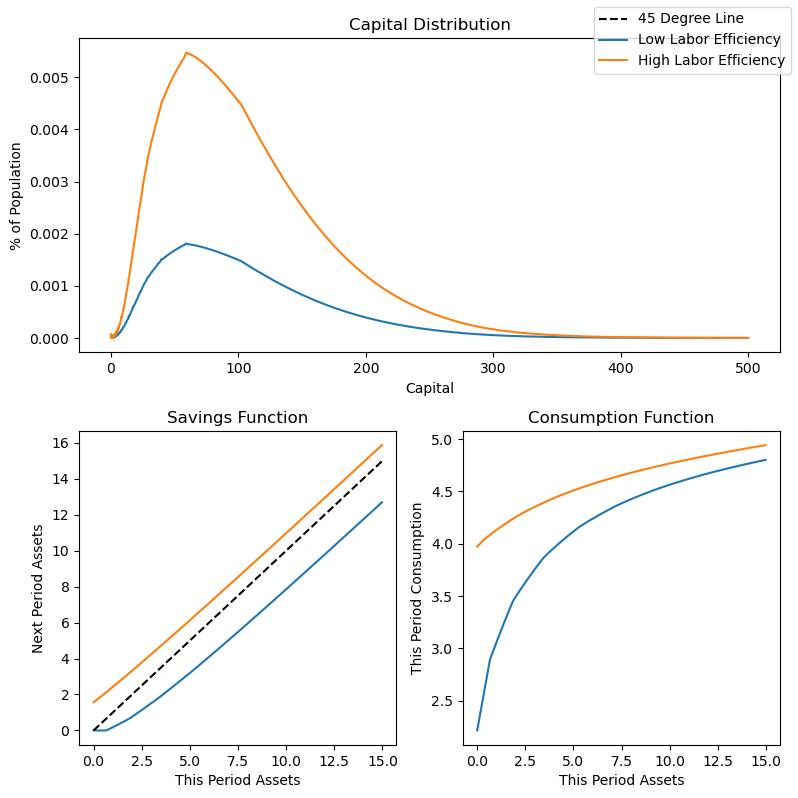

In [11]:
b_l0 = 10 + 0.1 * np.tile(GRID, PRODUCTIVITY.shape+(1,)).T  # intial guess we make here and update in the function to make the next iteration faster
def simulate_K(K, grid=GRID, b_l0=b_l0):
    R, W, Y = get_aggs(K)  # aggregate variables
    b_l = egm(b_l0, R, W)  # use the egm to solve for a policy rule
    b_l0[:] = b_l  # make next iteration faster
    dist = get_dist(g_interp(grid, b_l))  # get the distribution of capital
    K_d = agg_K(dist)

    return K_d, R, W, Y, b_l, dist


# params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital
K_0 = ((1/BETA + DELTA - 1) / ALPHA / L**(1-ALPHA))**(1/(ALPHA-1))  # steady state RBC K
K_ss = brentq(lambda K: simulate_K(K)[0] - K, K_0, K_0+2., xtol=capital_tol, maxiter=capital_max_iter)
_, R_ss, W_ss, Y_ss, b_l_ss, dist_ss = simulate_K(K_ss)
g_ss = lambda b_l: g_interp(b_l, b_l_ss)
c_ss = lambda b_l: R_ss*b_l[:, None] + W_ss*PRODUCTIVITY - g_ss(b_l)

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(GRID, dist_ss[:, 0], label='Low Labor Efficiency')
axtop.plot(GRID, dist_ss[:, 1], label='High Labor Efficiency')
n = (GRID < 15).sum()  # look at first n gridpoits, most the interesting stuff happens early
axs[1, 0].plot(GRID[:n], g_ss(GRID)[:n])
axs[1, 0].plot([A_MIN, GRID[n-1]], [A_MIN, GRID[n-1]], 'k--', label='45 Degree Line')
axs[1, 1].plot(GRID[:n], c_ss(GRID)[:n])

# final things
fig.legend()
fig.tight_layout()

#### MIT Shocks
We'll simulate the effects of a perfect foresight, "MIT" shock. To do this, we'll assume an unexpected shock hits at $t=0$ and that going forward agents in the economy have perfect information about the path of the shock. This eliminates most precautionary saving from the magnitude of variation in the economy, but this does get the same result as a first-order linear solution to the model.

For the economy's response to the MIT shock, we'll assume some shock of size $\sigma_Z$ hits at $t=0$ and that the economy returns to the steady state by $t=T$. Using the law of motion for productivity, we'll find the path $\{Z_t\}_{t=0}^T$. Then, the solution will be a path $\{K_t\}_{t=0}^T$ which gives us $\{R_t, W_t, Y_t\}_{t=0}^T$ and a path for the policy savings rule $\{g_t\}_{t=0}^T$ which gives us the evolution of the wealth distribution $\{D_t\}_{t=0}^T$.

In [12]:
# shock params
T = 500

# shock path
Z_path = np.exp(SIGMA_Z * np.full(T, RHO_Z) ** np.arange(T))
# Z_path = np.hstack((np.ones(50), np.exp(np.full(T-50, RHO_Z).cumprod() * SIGMA_Z / RHO_Z)))  # news shock

#### MIT Shocks Naive Solution Method
To solve for the model's response we'll assume a path for $\{K_t\}_{t=0}^T$. Then, we'll
1. Find the paths for prices in the economy
2. Starting at $t=T$ and assuming $g_{T+1} = g_{ss}$, we'll solve backwards using the Endogenous Grid method to find a path for the policy rules $\{g_t\}_{t=0}^T$
3. Starting at $t=0$, simulate how the distribution of wealth evolves from the steady state distribution based on our policy functions
4. Use the path for the distribution of wealth to find $\{\tilde K_t\}_{t=0}^T$, the aggregate capital owned by households
Then, we'll update our guess for $\{K_t\}_{t=0}^T$ as a convex combination of $K_t$ and $\tilde K_t$. to get
$$
    K_t := s K_t + (1-s) \tilde K_t
$$
and repeat the process until $K_t$ and $\tilde K_t$ converge for all values of $t$.

#### Aggregate Paths
Aggregates follow the same equations used in the steady state, just with the addition of the shock values.

In [13]:
@nb.njit
def get_agg_paths(K_path, Z_path, K_ss=K_ss, T=T):
    '''
    Get the aggregate paths for a given guess of K_path after a shock
    '''
    # instanticate paths
    R_path = np.empty_like(K_path)
    W_path = np.empty_like(K_path)
    Y_path = np.empty_like(K_path)

    # first values (use steady state capital)
    R_path[0], W_path[0], Y_path[0] = get_aggs(K_ss, Z_path[0])

    # use z_t and k_l to get each one after that
    for t in nb.prange(1, T):
        R_path[t], W_path[t], Y_path[t] = get_aggs(K_path[t-1], Z_path[t])
    
    return R_path, W_path, Y_path

#### Policy Rules
We can work backwards using the budgets and Euler Equations to solve for a policy rule for each period.

In [14]:
@nb.njit
def get_savings_path(R_path, W_path, b_l_ss=b_l_ss, R_ss=R_ss, W_ss=W_ss, T=T):
    '''
    Trace backwards a path for the savings rule
    '''
    # instantiate path
    b_l_path = np.empty((len(R_path), len(GRID), 2))  # b_l_path[t] should be b_l at time t

    # final period
    b_l_path[-1] = euler_back(b_l_ss, R_path[-1], W_path[-1], R_ss, W_ss)  # last time, t+1 we're assuming is steady state

    # work backwards to find the 
    for t in range(T-2, -1, -1):  # need to be done in order -> range instead of prange
        b_l_path[t] = euler_back(b_l_path[t+1], R_path[t], W_path[t], R_path[t+1], W_path[t+1])
    
    return b_l_path

#### Distributions
Use the savings rules we found in order to simulate the distribution of wealth over time. In this step, we also aggregate to get a path for $\{\tilde K_t\}_{t=0}^T$.

In [15]:
def get_dist_path(b_l_path, T=T, dist_ss=dist_ss, grid=GRID):
    '''
    Simulate the distribution of wealth over time in response to the shock
    using our policy rules
    '''
    # instantiate paths
    dist_path = np.empty_like(b_l_path)
    K_d_path = np.empty(T)

    # t=0, wealth evolves from the steady state
    tran_mat = make_tran_mat(g_interp(grid, b_l_path[0]))  # is it worth not using sparse matricies so i can jit it?
    dist = tran_mat @ dist_ss.ravel('F')
    dist_path[0] = dist.reshape((-1, 2), order='F')
    K_d_path[0] = agg_K(dist_path[0])

    # changes as time goes on
    for t in range(1, T):
        tran_mat = make_tran_mat(g_interp(grid, b_l_path[t]))
        dist = tran_mat @ dist  # update distribution
        dist_path[t] = dist.reshape((-1, 2), order='F')
        K_d_path[t] = agg_K(dist_path[t])

    return dist_path, K_d_path

#### Combined Algorithm
For a given guess of $\{K_t\}_{t=0}^T$, we'll go through all the above steps above and check whether the amount of capital implied by the wealth distribution $\{\tilde K_t\}_{t=0}^T$ matches the initial guess. If it doesn't we'll implement the convex combination update rule.

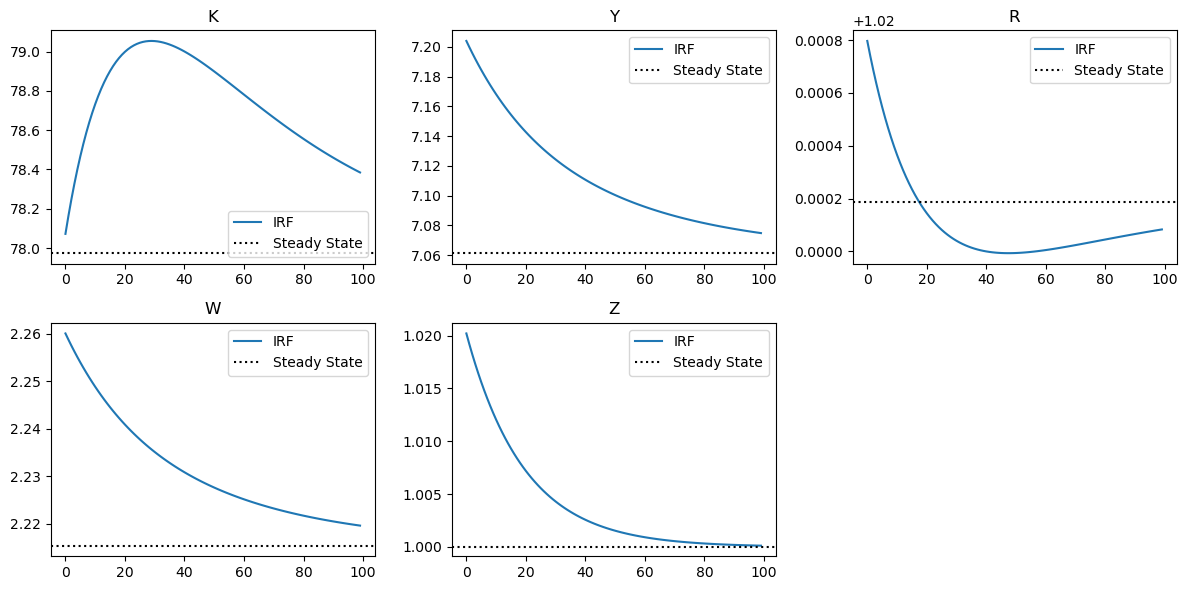

In [17]:
def simulate_K_path(K_path, Z_path):
    '''
    Simulate a guess for K_path to find the economy given the guess
    '''
    R_path, W_path, Y_path = get_agg_paths(K_path, Z_path)
    b_l_path = get_savings_path(R_path, W_path)
    dist_path, K_d_path = get_dist_path(b_l_path)

    return K_d_path, R_path, W_path, Y_path, b_l_path, dist_path


def find_K_path(Z_path, K_path_0, s=0.8, max_iter=1000, tol=1e-10):
    '''
    Find the steady state path for K
    '''
    K_path = K_path_0  # intial guess
    for _ in range(max_iter):
        K_d_path, R_path, W_path, Y_path, b_l_path, dist_path = simulate_K_path(K_path, Z_path)

        # exit condition
        diff = np.abs(K_path - K_d_path).max()  # difference between guessed path and implied path
        if diff < tol:
            break

        # update rule
        K_path = s * K_path + (1-s) * K_d_path
    else:
        warnings.warn('Max iteration count exceeded')

    return K_path, R_path, W_path, Y_path, b_l_path, dist_path


# find a path
K_path_0 = np.full(T, K_ss)
K_path, R_path, W_path, Y_path, b_l_path, dist_path = find_K_path(Z_path, K_path_0)

# plot it
t = 100  # plot this many time periods
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
titles = ['K', 'Y', 'R', 'W', 'Z']
paths = [K_path, Y_path, R_path, W_path, Z_path]
sss = [K_ss, Y_ss, R_ss, W_ss, 1.]
for i in range(5):
    ax = axs.take(i)
    ax.plot(paths[i][:t], label='IRF')
    ax.axhline(sss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
axs[1, 2].set_axis_off()
fig.tight_layout()

In [19]:
# animation
# setup plot
n = (GRID < 50).sum()  # look at first n gridpoits, most the interesting stuff happens early
fig, axs = plt.subplots(2, 2)
fig.suptitle('t=0')
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Wealth Distribution')
axtop.set_xlabel('Wealth')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 1.1*max([d.max() for d in dist_path])))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('% Deviation from Steady State')
axs[1, 0].set_xlim((A_MIN, GRID[n-1]))
axs[1, 0].axhline(0., color='k', linestyle=':')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('% Deviation from Steady State')
axs[1, 1].set_xlim((A_MIN, GRID[n-1]))
axs[1, 1].axhline(0., color='k', linestyle=':')

# plot it
ln_dist_low, = axtop.plot([], [], label='Employed')
ln_dist_high, = axtop.plot([], [], label='Unemployed')
ln_g_low, = axs[1, 0].plot([], [])
ln_g_high, = axs[1, 0].plot([], [])
ln_c_low, = axs[1, 1].plot([], [])
ln_c_high, = axs[1, 1].plot([], [])

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(GRID, dist_t[:, 0])
    ln_dist_high.set_data(GRID, dist_t[:, 1])

    # update savings
    b_l = b_l_path[t]
    g_t = lambda b: g_interp(b, b_l)
    savings = (g_t(GRID) - g_ss(GRID)) / np.where(g_ss(GRID) != 0, g_ss(GRID), 1.)
    ln_g_low.set_data(GRID[:n], savings[:n, 0])
    ln_g_high.set_data(GRID[:n], savings[:n, 1])

    # update consumption
    c_t = lambda b: R_path[t]*b[:, None] + W_path[t]*PRODUCTIVITY - g_ss(b)
    consumption = (c_t(GRID) - c_ss(GRID)) / c_ss(GRID)
    ln_c_low.set_data(GRID[:n], consumption[:n, 0])
    ln_c_high.set_data(GRID[:n], consumption[:n, 1])


# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=100, interval=50, repeat=False)  # only look at first few hundred periods
HTML(anim.to_html5_video())